In [1]:

import matplotlib.pyplot as matPlt
import numpy as np
import tensorflow as tf
from tqdm.keras import TqdmCallback

from rasterio.merge import merge as rasterMerge
from rasterio.mask import mask as rasterMask
from rasterio.plot import reshape_as_raster, reshape_as_image
from shapely.geometry import Polygon, box

import keras
from keras import layers
import rasterio

import junodch_utils_read_img as utils

# Data preparation
### Fetch data from file

In [2]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
pathNight = folderName + "Night VIIRS_1.tif"
#pathNight = folderName + "lowres_night_1.tif"
pathValidation = folderName + "Population GHSL_1.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, area=aoi)
print('Tiles:',dataCoords.shape[0])


Tiles: 554961


In [3]:
trainMask = dataRadiance>100
lightCoords = dataCoords[trainMask]

print('Tiles:',dataCoords.shape[0])
print('Light Tile:',lightCoords.shape[0])

Tiles: 554961
Light Tile: 2928


In [4]:
with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.coordsToImgsFormated(f, lightCoords, res=32)
print(trainData.shape)

(2928, 32, 32, 3)


# Autoencoder

In [21]:
# Input encoder
input_shape = trainData.shape[1:]

#optimizer = 'adam'
optimizer = keras.optimizers.Adam(
  learning_rate=0.001,
  beta_1=0.9,
  beta_2=0.999,
)

#lossFunction = keras.losses.MeanAbsoluteError() # L1
lossFunction = keras.losses.MeanSquaredError() # l2
#lossFunction = tf.keras.losses.KLDivergence()

activationFunction = lambda x: tf.keras.activations.relu(x, max_value=255)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=3)

autoencoder = keras.Sequential([
  layers.Conv2D(32,(3,3), 2, padding='same', activation='relu', input_shape=input_shape),
  layers.Conv2D(32,(3,3), 2, padding='same', activation='relu'),
  layers.Conv2D(32,(3,3), 2, padding='same', activation='relu'),

  layers.Flatten(name='encoder'),
  layers.Reshape(target_shape=(4,4,32)),

  layers.Conv2DTranspose(32,(3,3), 2, padding='same', activation='relu'),
  layers.Conv2DTranspose(32,(3,3), 2, padding='same', activation='relu'),

  layers.Conv2DTranspose(3, (3,3), 2, padding='same', activation='sigmoid', name='decoder'),
])

autoencoder.compile(optimizer=optimizer, loss=lossFunction)

print('Encoder shape:',autoencoder.get_layer('encoder').output_shape)

autoencoder.get_output_shape_at

result = autoencoder.fit(trainData, trainData,
                          epochs=30,
                          batch_size=2,
                          shuffle=True,
                          verbose=0,
                          callbacks=[
                            TqdmCallback(verbose=1), # Concise display progression
                            earlyStop,
                          ],
                        )


Encoder shape: (None, 256)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 conv2d_16 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 32)          9248      
                                                                 
 encoder (Flatten)           (None, 512)               0         
                                                                 
 reshape_5 (Reshape)         (None, 4, 4, 32)          0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 8, 8, 32)         9248      
 Transpose)                                                      
                                                      

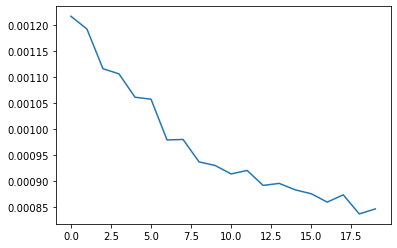

In [17]:
matPlt.plot(result.history['loss'][10:], label='Training')
autoencoder.summary()

Test display some tiles
Original data: (40, 32, 32, 3)


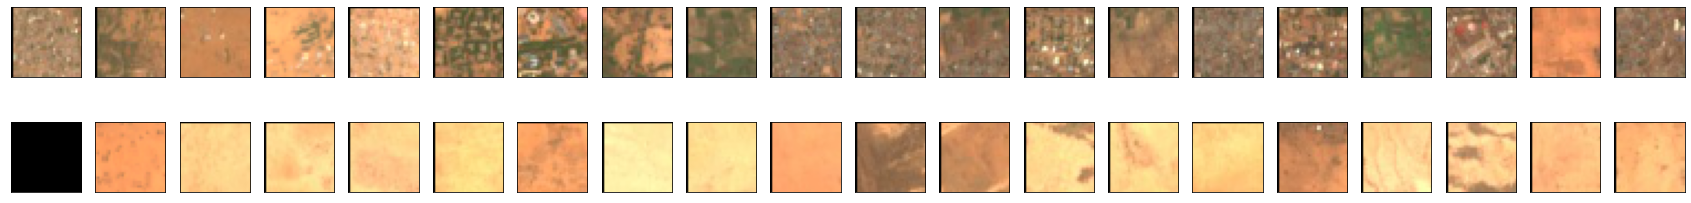

2/2 [==============================] - 0s 8ms/step
Output data: (40, 32, 32, 3)


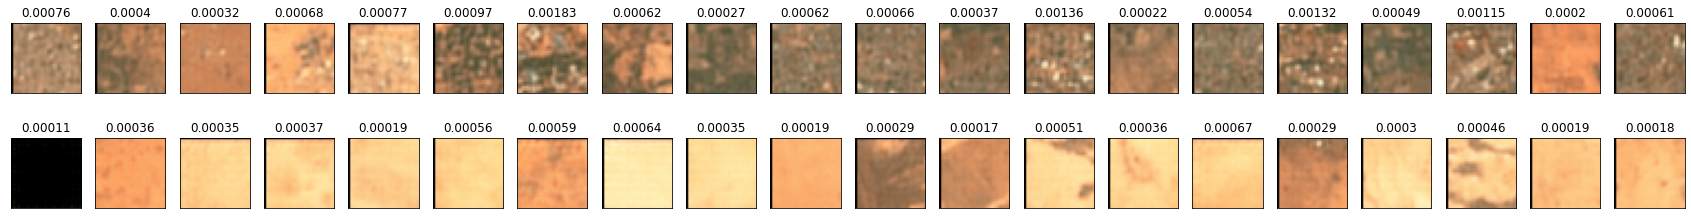

In [18]:
print("Test display some tiles")

# sample with 64x64 images
#indexesTest = [*np.argwhere(trainMask)[-20:].flatten(), *range(0,1), *range(1104,1108), *range(1118,1123), *range(4005,4010), *range(10005,10010)]
# sample with 32x32 images
indexesTest = [*np.argwhere(trainMask)[100:600:25].flatten(), *range(0,100000,5000)]

with rasterio.open(pathSatellite) as f:
  dataTest, _ = utils.coordsToImgsFormated(f, dataCoords[indexesTest], res=32)

utils.displayAutoEncoderResults(autoencoder, dataTest, showDetail=0, precision=5)

In [19]:
autoencoder.save('model/autoencoder_32px_encoder_512')

INFO:tensorflow:Assets written to: model/autoencoder_32px_encoder_512\assets


INFO:tensorflow:Assets written to: model/autoencoder_32px_encoder_512\assets
